In [46]:
import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading the data

In [128]:
data_train = pd.read_csv("train.csv", sep=',', encoding='latin1')
data_test = pd.read_csv("test.csv", sep=',', encoding='latin1')
data_submission = pd.read_csv("sample_submission.csv", sep=',', encoding='latin1')

In [129]:
data_train = data_train.dropna()

In [130]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
textID           27480 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27480 non-null object
dtypes: object(4)
memory usage: 1.0+ MB


In [132]:
data_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [134]:
data_submission.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


# Exploratory Data Analysis

In [197]:
from sklearn.base import BaseEstimator, TransformerMixin
import emoji
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
import collections

In [135]:
sentiment_count=data_train.groupby('sentiment').count()
sentiment_count

,textID,text,selected_text
sentiment,,,
negative,7781,7781,7781
neutral,11117,11117,11117
positive,8582,8582,8582


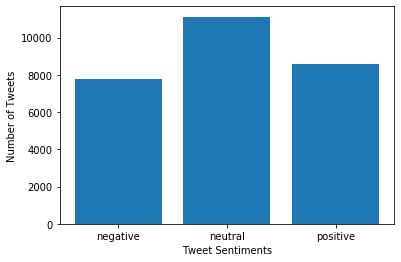

In [136]:
sentiment_count=data_train.groupby('sentiment').count()
plt.bar(sentiment_count.index.values, sentiment_count['textID'])
plt.xlabel('Tweet Sentiments')
plt.ylabel('Number of Tweets')
plt.show()

In [141]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df
    

In [178]:
tc = TextCounts()
df_eda = tc.fit_transform(data_train.text)
# Add airline_sentiment to df_eda
df_eda['sentiment'] = data_train.sentiment

In [186]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
             count       mean       std  min  25%   50%   75%   max
sentiment                                                          
negative    7781.0  13.993831  7.119993  0.0  8.0  13.0  20.0  36.0
neutral    11117.0  12.873707  7.317337  0.0  7.0  12.0  18.0  47.0
positive    8582.0  13.609532  6.951817  1.0  8.0  13.0  19.0  40.0


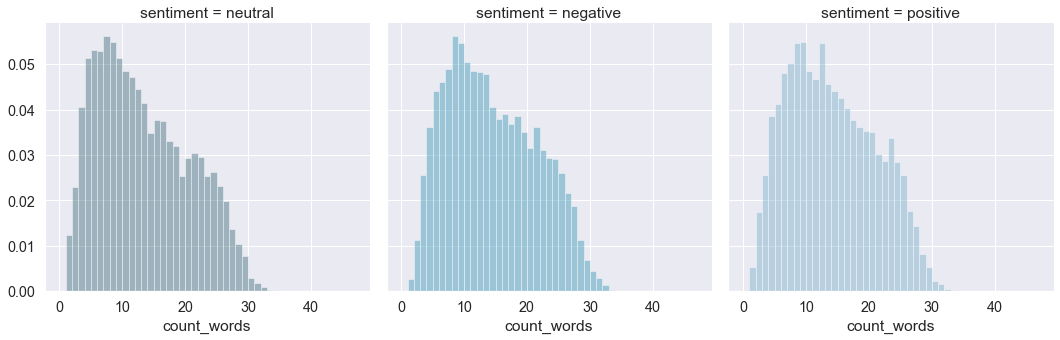

In [187]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_hashtags
------------------------------------
             count      mean       std  min  25%  50%  75%  max
sentiment                                                      
negative    7781.0  0.021977  0.164778  0.0  0.0  0.0  0.0  3.0
neutral    11117.0  0.022218  0.170069  0.0  0.0  0.0  0.0  4.0
positive    8582.0  0.021091  0.169035  0.0  0.0  0.0  0.0  5.0


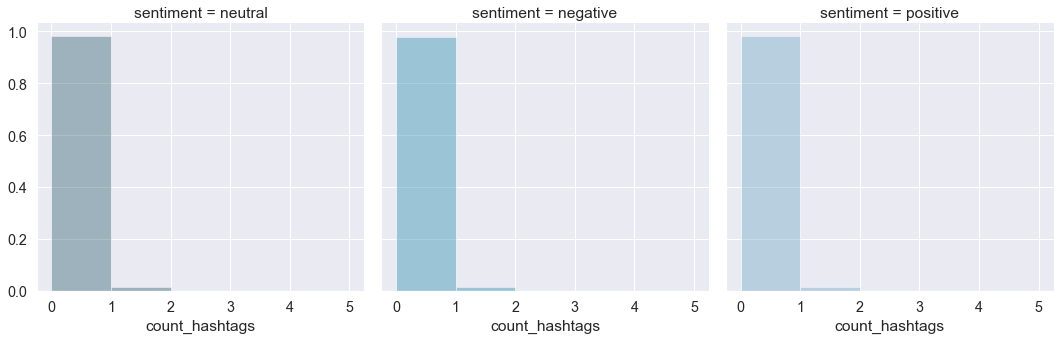

In [188]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
             count      mean       std  min  25%  50%  75%   max
sentiment                                                       
negative    7781.0  0.266418  1.054719  0.0  0.0  0.0  0.0  22.0
neutral    11117.0  0.244940  1.086657  0.0  0.0  0.0  0.0  26.0
positive    8582.0  0.277558  1.035488  0.0  0.0  0.0  0.0  24.0


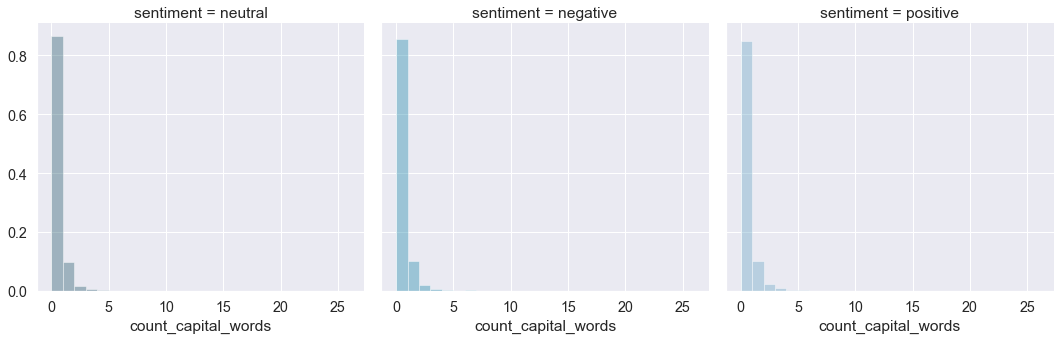

In [189]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
             count      mean       std  min  25%  50%  75%   max
sentiment                                                       
negative    7781.0  0.644390  1.609461  0.0  0.0  0.0  1.0  59.0
neutral    11117.0  0.636413  1.675780  0.0  0.0  0.0  1.0  98.0
positive    8582.0  0.870776  1.518472  0.0  0.0  0.0  1.0  42.0


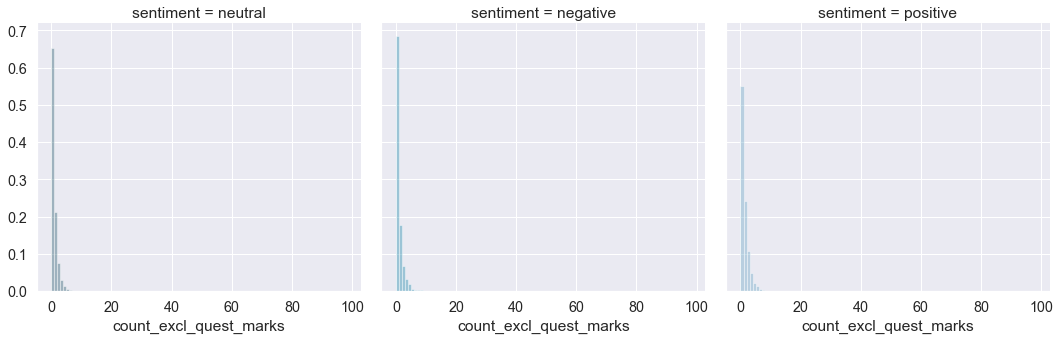

In [190]:
show_dist(df_eda, 'count_excl_quest_marks')

# Text Cleaning
Before we start using the tweets' text we clean it. We'll do the this in the class CleanText:
- remove the **mentions**, as we want to make the model generalisable to tweets of other airline companies too.
- remove the **hash tag sign** (#) but not the actual tag as this may contain information
- set all words to **lowercase**
- remove all **punctuations**, including the question and exclamation marks
- remove the **urls** as they do not contain useful information and we did not notice a distinction in the number of urls used between the sentiment classes
- make sure the converted **emojis** are kept as one word. 
- remove **digits**
- remove **stopwords**
- apply the **PorterStemmer** to keep the stem of the words

In [192]:
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [194]:
ct = CleanText()
sr_clean = ct.fit_transform(data_train.text)
sr_clean.sample(5)

13815       sound like perfect way spend sunday even enjoy
4261                         super hungri wait biotch feed
8987     definit make challeng curl lash tine moisturis...
24948                                                 game
24214    yah footlong sausag mah halal place piggi saus...
Name: text, dtype: object

In [195]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

77 records have no words left after text cleaning


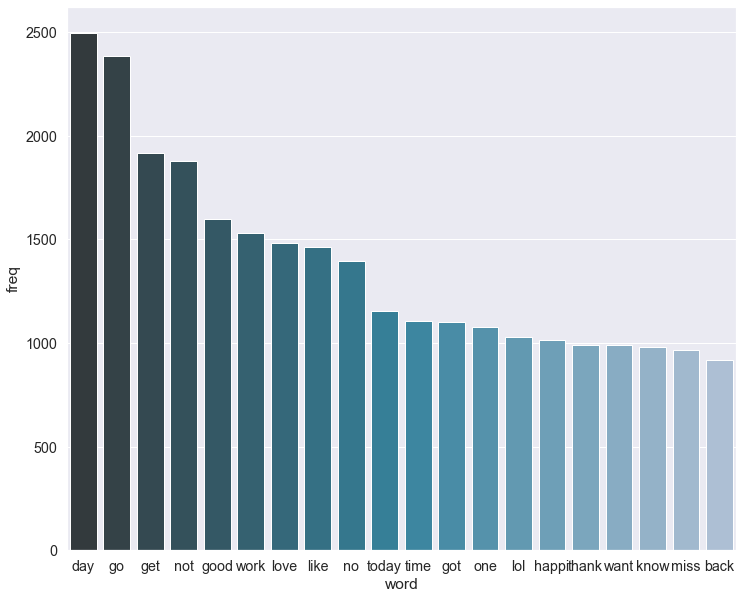

In [199]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [19]:
positive_tweets = data_train.loc[data_train['sentiment'] == 'positive']
negative_tweets = data_train.loc[data_train['sentiment'] == 'negative']
neutral_tweets = data_train.loc[data_train['sentiment'] == 'neutral']

In [18]:
positive_tweets

,textID,text,selected_text,sentiment
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive
11,16fab9f95b,I really really like the song Love Story by Ta...,like,positive
21,e48b0b8a23,Playing Ghost Online is really interesting. Th...,interesting.,positive
25,e00c6ef376,"the free fillin` app on my ipod is fun, im add...","the free fillin` app on my ipod is fun, im add...",positive
...,...,...,...,...
27467,432e6de6c9,morning twit-friends! welcome to my new followers,welcome,positive
27474,8f14bb2715,So I get up early and I feel good about the da...,I feel good ab,positive
27475,b78ec00df5,enjoy ur night,enjoy,positive
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive


In [20]:
negative_tweets

,textID,text,selected_text,sentiment
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative
...,...,...,...,...
27464,e7eecffdc8,rec game....trying not to cry...the pain is to...,breakingg,negative
27470,778184dff1,lol i know and haha..did you fall asleep?? o...,t bored,negative
27472,8f5adc47ec,http://twitpic.com/663vr - Wanted to visit the...,were too late,negative
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative


In [21]:
neutral_tweets

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral
...,...,...,...,...
27468,a753a93e45,"few grilled mushrooms and olives, feta cheese ...","few grilled mushrooms and olives, feta cheese ...",neutral
27469,ac92790d8b,94 more days till BH comes back to LA,94 more days till BH comes back to LA,neutral
27471,15bb120f57,"i`m defying gravity. and nobody in alll of oz,...","i`m defying gravity. and nobody in alll of oz,...",neutral
27473,a208770a32,in spoke to you yesterday and u didnt respond...,in spoke to you yesterday and u didnt respond ...,neutral


In [25]:
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [ ]:
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))